
# Calendar Averaging
This script illustrates the following concepts:

- Usage of geocat-comp's [calendar_average](https://geocat-comp.readthedocs.io/en/stable/user_api/generated/geocat.comp.climatologies.calendar_average.html) function.
- Usage of geocat-datafiles for accessing NetCDF files
- Creating a figure with stacked subplots


## Import packages

Dependencies:

- geocat.comp
- [geocat.datafiles](https://github.com/NCAR/geocat-datafiles) (for accessing data file only)
- [cftime](https://unidata.github.io/cftime/) (installed with geocat.comp)
- [matplotlib](https://matplotlib.org/) (installed with geocat.viz)
- [xarray](https://docs.xarray.dev/en/stable/) (installed with geocat.comp)

In [1]:
import cftime
import matplotlib.pyplot as plt
import xarray as xr

from geocat.comp import calendar_average
import geocat.datafiles as gdf
import geocat.viz as gv

/Users/jkentadmin/miniconda3/envs/geocatsandbox/lib/python3.10/site-packages/geocat/viz/__init__.py:7: UserWarning: GeoCAT packages will no longer be published on the ncar channel, switch to conda-forge
  warnings.warn("GeoCAT packages will no longer be published on the ncar channel, switch to conda-forge")


## Read in data

We will get the data from the [geocat-datafiles](https://github.com/NCAR/geocat-datafiles) package. This package contains example data used in many of the examples for geocat packages.

Then, we use xarray's [open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) function to read the data into an xarray dataset, choose a single model from the ensemble run, and extract its surface temperature data into `temp`

In [2]:
ds = xr.open_dataset(gdf.get('netcdf_files/atm.20C.hourly6-1990-1995-TS.nc'))
ds = ds.isel(member_id=0)  # select one model from the ensemble

temp = ds.TS  # surface temperature data

## Calculate daily, monthly, and seasonal averages using `calendar_average`

In [3]:
daily = calendar_average(temp, 'day')
monthly = calendar_average(temp, 'month')
season = calendar_average(temp, 'season')

# Convert datetimes to number of hours since 1990-01-01 00:00:00
# This must be done in order to use the time for the x axis
time_num_raw = cftime.date2num(temp.time, 'hours since 1990-01-01 00:00:00')
time_num_day = cftime.date2num(daily.time, 'hours since 1990-01-01 00:00:00')
time_num_month = cftime.date2num(monthly.time,
                                 'hours since 1990-01-01 00:00:00')
time_num_season = cftime.date2num(season.time,
                                  'hours since 1990-01-01 00:00:00')

# Start and end time for axes limits in units of hours since 1990-01-01 00:00:00
tstart = time_num_raw[0]
tend = time_num_raw[-1]

## Plot

The top subplot is raw surface temperature data from a model run with a
temporal resolution of 6-hours.

The second subplot shows the output of the raw data being aggregated using the
`calendar_average` function with the `freq` argument set to `daily`. This
function averages all data points within each 24-hour period.

The third subplot shows the output of `calendar_average` with the `freq`
argument set to `monthly`. This works much the same as for the middle plot;
however, the data is now grouped by month which yields a smoother curve.

The bottom subplot shows the output of `calendar_average` with the `freq`
argument set to `season`. This averages all data points in each meteorological
season. Those seasons are each comprised of three month periods with the first
consisting of December, January, and February for meteorological winter.

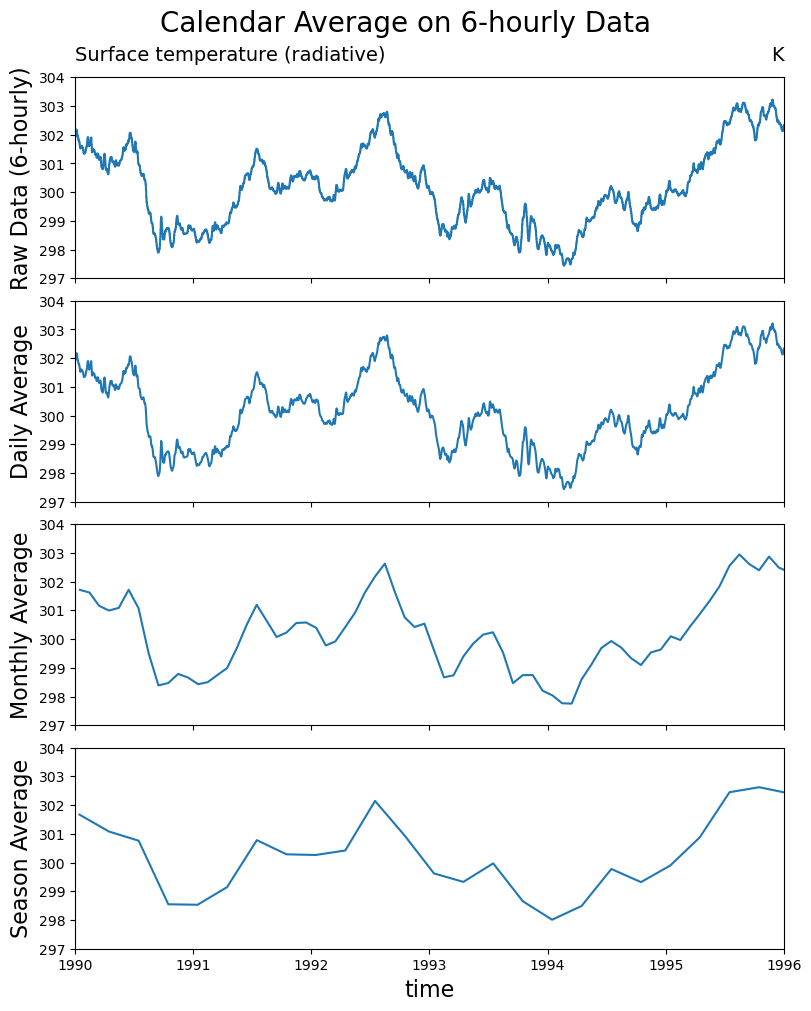

In [4]:
# Make three subplots with shared axes
fig, ax = plt.subplots(4,
                       1,
                       figsize=(8, 10),
                       sharex=True,
                       sharey=True,
                       constrained_layout=True)

# Plot data
ax[0].plot(time_num_raw, temp.data)
ax[1].plot(time_num_day, daily.data)
ax[2].plot(time_num_month, monthly.data)
ax[3].plot(time_num_season, season.data)

# Use geocat.viz.util convenience function to set axes parameters without
# calling several matplotlib functions
gv.set_axes_limits_and_ticks(ax[0],
                             xlim=(tstart, tend + 1),
                             xticks=range(tstart, tend + 1, 365 * 24),
                             xticklabels=range(1990, 1997),
                             ylim=(297, 304))

# Use geocat.viz.util convenience function to set titles and labels
gv.set_titles_and_labels(ax[0],
                         ylabel='Raw Data (6-hourly)',
                         lefttitle=temp.long_name,
                         lefttitlefontsize=14,
                         righttitle=temp.units,
                         righttitlefontsize=14)

gv.set_titles_and_labels(ax[1], ylabel='Daily Average')

gv.set_titles_and_labels(ax[2], ylabel='Monthly Average')

gv.set_titles_and_labels(ax[3],
                         ylabel='Season Average',
                         xlabel=temp.time.long_name)

# Add title manually to control spacing
fig.suptitle('Calendar Average on 6-hourly Data', fontsize=20)

plt.show()